# Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B

На сайте запущен А/В тест с целью увеличить доход.  
В приложенном excel файле вы найдете сырые данные  
по результатам эксперимента – user_id,  
тип выборки variant_name  
и доход принесенный пользователем revenue.

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [2]:
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy.stats import norm

import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [4]:
data = pd.read_csv('ab_stats.csv')
data.head(10)

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [6]:
data.shape

(23652, 5)

In [7]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [12]:
data.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [14]:
new_data = data[data['revenue'] > 0]
new_data

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


In [19]:
new_data[data['ab_group']=='B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,234.000000,234.000000,234.0,234.000000
mean,12.362119,1.841880,1.0,6.844776
std,19.007065,2.354021,0.0,3.970112
min,0.259373,1.000000,1.0,-5.646523
25%,2.319883,1.000000,1.0,4.009016
50%,3.980000,1.000000,1.0,7.143956
75%,12.274829,2.000000,1.0,9.776519
max,113.830000,25.000000,1.0,16.955948


In [20]:
new_data[data['ab_group']=='A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,256.000000,256.000000,256.0,256.000000
mean,18.698469,2.343750,1.0,6.753074
std,87.527589,9.723582,0.0,2.043753
min,0.259689,1.000000,1.0,0.996753
25%,2.318301,1.000000,1.0,5.281247
50%,4.283160,1.000000,1.0,6.871241
75%,11.923141,2.000000,1.0,8.257506
max,1303.609284,152.000000,1.0,12.504262


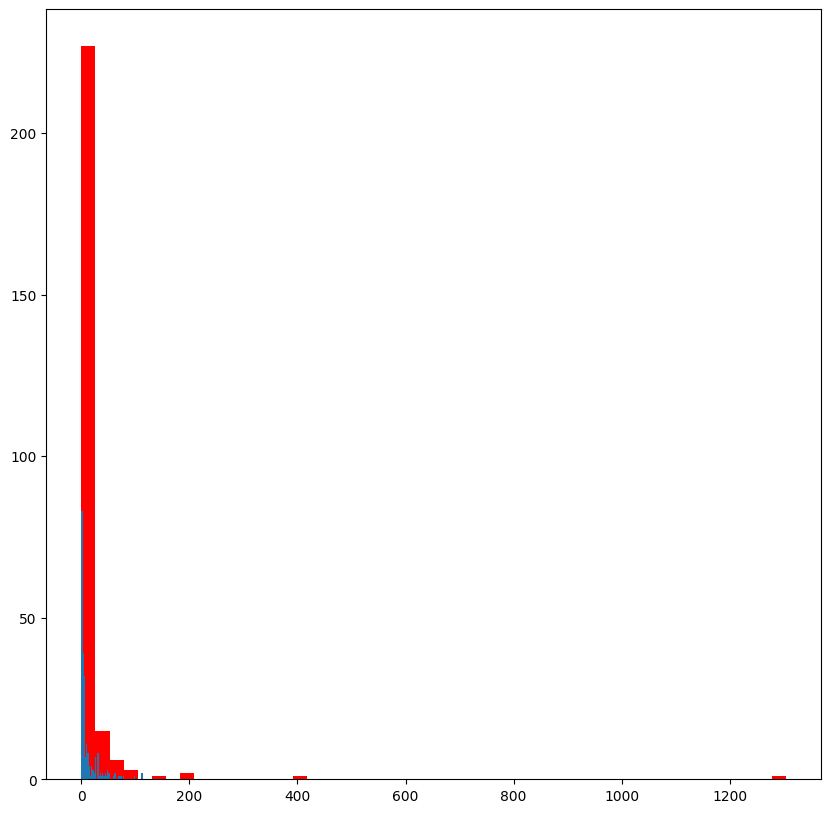

In [23]:
plt.figure(figsize=(10, 10))
control_visit_all = new_data['revenue'][data['ab_group']=='A']
test_visit_all = new_data['revenue'][data['ab_group']=='B']

plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all, bins=50)

plt.show()

In [24]:
ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=1.1295123189663723, pvalue=0.2596444677902523)

pvalue > 0.05  
Значимых изменений нет

In [25]:
print(kstest(control_visit_all, 'norm'))
print(kstest(test_visit_all, 'norm'))

KstestResult(statistic=0.8312038740127529, pvalue=5.535202851866459e-197, statistic_location=1.9727, statistic_sign=-1)
KstestResult(statistic=0.8635160979681316, pvalue=1.877582850318663e-202, statistic_location=1.953625, statistic_sign=-1)


pvalue < 0.05  
Отвергаем нулевую гипотезу - распределение данных не нормальное

In [26]:
mannwhitneyu(control_visit_all, test_visit_all)

MannwhitneyuResult(statistic=29729.5, pvalue=0.8871956616344514)

pvalue > 0.05  
0 гипотеза не отвергается, статистически значимых изменений нет

In [27]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
            ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
            ).values

        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2480.15it/s]


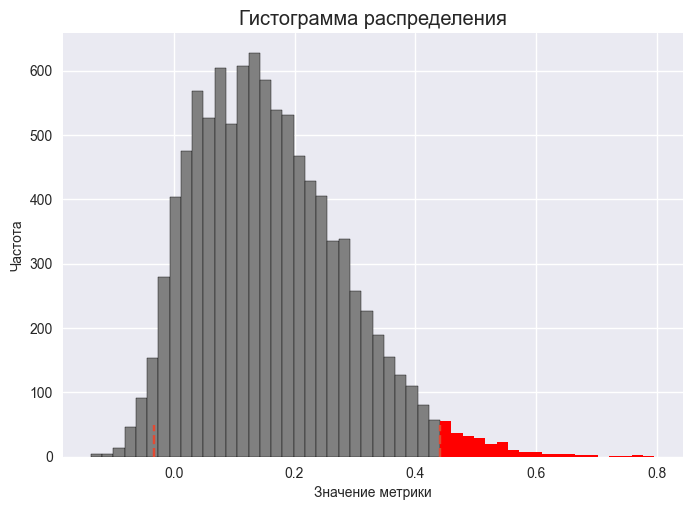

p_value 0.19916995364731582


In [28]:
plt.style.use('seaborn')
pd.options.display.float_format = '{:,.2f}'.format

booted_data = get_bootstrap(data['revenue'][data['ab_group']=='A'],
                            data['revenue'][data['ab_group']=='B'],
                            boot_it = 10000)

print('p_value', booted_data['p_value'])

p_value > 0.05  
Нет статистической значимости  

Ответ: Нулевая гипотеза не отвергается, оставляем исходный вариант